# Pairs Selection using Cointegration Tests & Kalman Filter

## Imports & Settings

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from collections import Counter

from time import time
from pathlib import Path

import numpy as np
import pandas as pd

from pykalman import KalmanFilter
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt

In [153]:
idx = pd.IndexSlice
sns.set_style('whitegrid')

In [8]:
DATA_PATH = Path('..', 'data') 

In [9]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

### Johansen Test Critical Values

In [10]:
critical_values = {0: {.9: 13.4294, .95: 15.4943, .99: 19.9349},
                   1: {.9: 2.7055, .95: 3.8415, .99: 6.6349}}

In [11]:
trace0_cv = critical_values[0][.95] # critical value for 0 cointegration relationships
trace1_cv = critical_values[1][.95] # critical value for 1 cointegration relationship

## Load Data

In [12]:
DATA_PATH = Path('..', 'data') 
STORE = DATA_PATH / 'stooq' / 'daily.h5'

### Get backtest prices

Combine OHLCV prices for relevant stock and ETF tickers.

In [154]:
def get_backtest_prices():
    with pd.HDFStore('data.h5') as store:
        tickers = store['tickers']

    with pd.HDFStore(STORE) as store:
        prices = (pd.concat([
            store['stooq/us/nyse/stocks/prices'],
            store['stooq/us/nyse/etfs/prices'],
            store['stooq/us/nasdaq/etfs/prices'],
            store['stooq/us/nasdaq/stocks/prices']])
                  .sort_index()
                  .loc[idx[tickers, '2016':'2019'], :])
    prices.to_hdf('backtest.h5', 'prices')
    tickers.to_hdf('backtest.h5', 'tickers')

In [155]:
# get_backtest_prices()

### Load Stock Prices

In [9]:
stocks = pd.read_hdf('data.h5', 'stocks/close').loc['2015':]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-01-02 to 2019-12-31
Columns: 172 entries, AA.US to YUM.US
dtypes: float64(172)
memory usage: 1.7 MB


### Load ETF Data

In [10]:
etfs = pd.read_hdf('data.h5', 'etfs/close').loc['2015':]
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-01-02 to 2019-12-31
Columns: 138 entries, AAXJ.US to YCS.US
dtypes: float64(138)
memory usage: 1.3 MB


### Load Ticker Dictionary

In [188]:
names = pd.read_hdf('data.h5', 'tickers').to_dict()

In [189]:
pd.Series(names).count()

309

## Precompute Cointegration

In [51]:
def test_cointegration(etfs, stocks, test_end, lookback=2):
    start = time()
    results = []
    test_start = test_end - pd.DateOffset(years=lookback) + pd.DateOffset(days=1)
    etf_tickers = etfs.columns.tolist()
    etf_data = etfs.loc[str(test_start):str(test_end)]

    stock_tickers = stocks.columns.tolist()
    stock_data = stocks.loc[str(test_start):str(test_end)]
    n = len(etf_tickers) * len(stock_tickers)
    j = 0
    for i, s1 in enumerate(etf_tickers, 1):
        for s2 in stock_tickers:
            j += 1
            if j % 1000 == 0:
                print(f'\t{j:5,.0f} ({j/n:3.1%}) | {time() - start:.2f}')
            df = etf_data.loc[:, [s1]].dropna().join(stock_data.loc[:, [s2]].dropna(), how='inner')
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                var = VAR(df)
                lags = var.select_order()
                result = [test_end, s1, s2]
                order = lags.selected_orders['aic']
                result += [coint(df[s1], df[s2], trend='c')[1], coint(df[s2], df[s1], trend='c')[1]]

            cj = coint_johansen(df, det_order=0, k_ar_diff=order)
            result += (list(cj.lr1) + list(cj.lr2) + list(cj.evec[:, cj.ind[0]]))
            results.append(result)
    return results

### Define Test Periods

In [ ]:
dates = stocks.loc['2016-12':'2019-6'].resample('Q').last().index
dates

### Run Tests

In [ ]:
test_results = []
columns = ['test_end', 's1', 's2', 'eg1', 'eg2',
           'trace0', 'trace1', 'eig0', 'eig1', 'w1', 'w2']

for test_end in dates:
    print(test_end)
    result = test_cointegration(etfs, stocks, test_end=test_end)
    test_results.append(pd.DataFrame(result, columns=columns))

pd.concat(test_results).to_hdf('backtest.h5', 'cointegration_test')

#### Reload  Test Results

In [54]:
test_results = pd.read_hdf('backtest.h5', 'cointegration_test')
test_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261096 entries, 0 to 23735
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   test_end  261096 non-null  datetime64[ns]
 1   s1        261096 non-null  object        
 2   s2        261096 non-null  object        
 3   eg1       261096 non-null  float64       
 4   eg2       261096 non-null  float64       
 5   trace0    261096 non-null  float64       
 6   trace1    261096 non-null  float64       
 7   eig0      261096 non-null  float64       
 8   eig1      261096 non-null  float64       
 9   w1        261096 non-null  float64       
 10  w2        261096 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 23.9+ MB


## Identify Cointegrated Pairs

### Significant Johansen Trace Statistic

In [55]:
test_results['joh_sig'] = ((test_results.trace0 > trace0_cv) &
                           (test_results.trace1 > trace1_cv))

In [56]:
test_results.joh_sig.value_counts(normalize=True)

False    0.946954
True     0.053046
Name: joh_sig, dtype: float64

### Significant Engle Granger Test

In [57]:
test_results['eg'] = test_results[['eg1', 'eg2']].min(axis=1)
test_results['s1_dep'] = test_results.eg1 < test_results.eg2
test_results['eg_sig'] = (test_results.eg < .05)

In [58]:
test_results.eg_sig.value_counts(normalize=True)

False    0.911454
True     0.088546
Name: eg_sig, dtype: float64

### Comparison Engle-Granger vs Johansen

In [59]:
test_results['coint'] = (test_results.eg_sig & test_results.joh_sig)
test_results.coint.value_counts(normalize=True)

False    0.986691
True     0.013309
Name: coint, dtype: float64

In [60]:
test_results = test_results.drop(['eg1', 'eg2', 'trace0', 'trace1', 'eig0', 'eig1'], axis=1)
test_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261096 entries, 0 to 23735
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   test_end  261096 non-null  datetime64[ns]
 1   s1        261096 non-null  object        
 2   s2        261096 non-null  object        
 3   w1        261096 non-null  float64       
 4   w2        261096 non-null  float64       
 5   joh_sig   261096 non-null  bool          
 6   eg        261096 non-null  float64       
 7   s1_dep    261096 non-null  bool          
 8   eg_sig    261096 non-null  bool          
 9   coint     261096 non-null  bool          
dtypes: bool(4), datetime64[ns](1), float64(3), object(2)
memory usage: 14.9+ MB


### Comparison

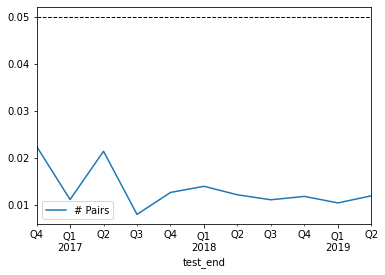

In [61]:
ax = test_results.groupby('test_end').coint.mean().to_frame('# Pairs').plot()
ax.axhline(.05, lw=1, ls='--', c='k');

### Select Candidate Pairs

In [64]:
def select_candidate_pairs(data):
    candidates = data[data.joh_sig | data.eg_sig]
    candidates['y'] = candidates.apply(lambda x: x.s1 if x.s1_dep else x.s2, axis=1)
    candidates['x'] = candidates.apply(lambda x: x.s2 if x.s1_dep else x.s1, axis=1)
    return candidates.drop(['s1_dep', 's1', 's2'], axis=1)

In [ ]:
candidates = select_candidate_pairs(test_results)

In [123]:
candidates.to_hdf('backtest.h5', 'candidates')

In [124]:
candidates = pd.read_hdf('backtest.h5', 'candidates')
candidates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33494 entries, 7 to 23734
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   test_end  33494 non-null  datetime64[ns]
 1   w1        33494 non-null  float64       
 2   w2        33494 non-null  float64       
 3   joh_sig   33494 non-null  bool          
 4   eg        33494 non-null  float64       
 5   eg_sig    33494 non-null  bool          
 6   coint     33494 non-null  bool          
 7   y         33494 non-null  object        
 8   x         33494 non-null  object        
dtypes: bool(3), datetime64[ns](1), float64(3), object(2)
memory usage: 1.9+ MB


#### # Candidates over Time

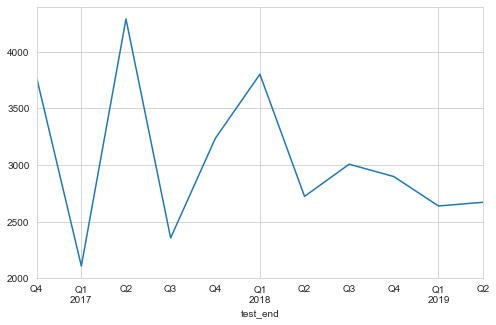

In [125]:
candidates.groupby('test_end').size().plot(figsize=(8,5));

#### Most Common Pairs 

In [192]:
with pd.HDFStore('data.h5') as store:
    print(store.info())
    tickers = store['tickers']

<class 'pandas.io.pytables.HDFStore'>
File path: data.h5
/etfs/close              frame        (shape->[2516,138])
/stocks/close            frame        (shape->[2516,172])
/tickers                 series       (shape->[1])       


In [199]:
with pd.HDFStore('backtest.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: backtest.h5
/candidates                    frame        (shape->[33494,9])  
/cointegration_test            frame        (shape->[261096,11])
/half_lives                    frame        (shape->[33494,4])  
/pair_data                     frame        (shape->[4208500,7])
/pair_trades                   frame        (shape->[1,6])      
/prices                        frame        (shape->[311857,5]) 
/tickers                       series       (shape->[1])        


In [80]:
counter = Counter()
for s1, s2 in zip(candidates[candidates.joh_sig & candidates.eg_sig].y, 
                  candidates[candidates.joh_sig & candidates.eg_sig].x):
    if s1 > s2:
        counter[(s2, s1)] += 1
    else: 
        counter[(s1, s2)] += 1

In [97]:
most_common_pairs = pd.DataFrame(counter.most_common(10))
most_common_pairs = pd.DataFrame(most_common_pairs[0].values.tolist(), columns=['s1', 's2'])
most_common_pairs

,s1,s2
0,T.US,VOX.US
1,FXF.US,MDLZ.US
2,FXF.US,NOV.US
3,FXF.US,RIG.US
4,AMJ.US,MDLZ.US
5,DIG.US,MDLZ.US
6,DJP.US,MDLZ.US
7,ERX.US,MDLZ.US
8,FXN.US,MDLZ.US
9,IYE.US,MDLZ.US


In [156]:
with pd.HDFStore('backtest.h5') as store:
    prices = store['prices'].close.unstack('ticker').ffill(limit=5)
    tickers = store['tickers'].to_dict()

In [157]:
cnt = pd.Series(counter).reset_index()
cnt.columns = ['s1', 's2', 'n']
cnt['name1'] = cnt.s1.map(tickers)
cnt['name2'] = cnt.s2.map(tickers)
cnt.nlargest(10, columns='n')

,s1,s2,n,name1,name2
1357,T.US,VOX.US,6,AT&T,VANGUARD COMMUNICATION SERVICES ETF
386,FXF.US,MDLZ.US,5,INVESCO CURRENCYSHARES SWISS FRANC TRUST,MONDELEZ INT
390,FXF.US,NOV.US,5,INVESCO CURRENCYSHARES SWISS FRANC TRUST,NATIONAL OILWELL VARCO
393,FXF.US,RIG.US,5,INVESCO CURRENCYSHARES SWISS FRANC TRUST,TRANSOCEAN
535,AMJ.US,MDLZ.US,5,JPMORGAN ALERIAN MLP INDEX ETN,MONDELEZ INT
550,DIG.US,MDLZ.US,5,PROSHARES ULTRA OIL & GAS,MONDELEZ INT
552,DJP.US,MDLZ.US,5,IPATH BLOOMBERG COMMODITY INDEX TR ETN,MONDELEZ INT
574,ERX.US,MDLZ.US,5,DIREXION DAILY ENERGY BULL 3X SHARES,MONDELEZ INT
633,FXN.US,MDLZ.US,5,FIRST TRUST ENERGY ALPHADEX FUND,MONDELEZ INT
647,IYE.US,MDLZ.US,5,ISHARES US ENERGY ETF,MONDELEZ INT


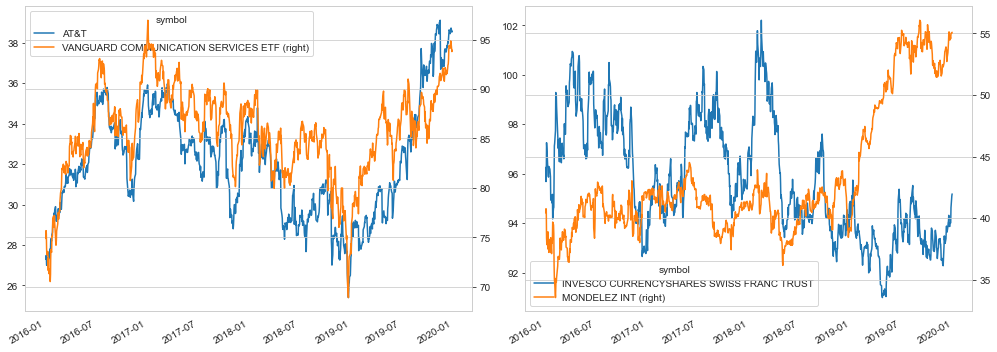

In [158]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
for i in [0, 1]:
    s1, s2 = most_common_pairs.at[i, 's1'], most_common_pairs.at[i, 's2']
    prices.loc[:, [s1, s2]].rename(columns=tickers).plot(secondary_y=tickers[s2], ax=axes[i])
    axes[i].grid(False)
    axes[i].set_xlabel('')

fig.tight_layout()
fig.savefig('figures/common_pairs', dpi=300)

## Get Entry and Exit Dates 

### Smooth prices using Kalman filter

In [159]:
def KFSmoother(prices):
    """Estimate rolling mean"""
    
    kf = KalmanFilter(transition_matrices=np.eye(1),
                      observation_matrices=np.eye(1),
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=.05)

    state_means, _ = kf.filter(prices.values)
    return pd.Series(state_means.flatten(),
                     index=prices.index)

In [160]:
smoothed_prices = prices.apply(KFSmoother)
smoothed_prices.to_hdf('tmp.h5', 'smoothed')

In [161]:
smoothed_prices = pd.read_hdf('tmp.h5', 'smoothed')

### Compute rolling hedge ratio using Kalman Filter

In [162]:
def KFHedgeRatio(x, y):
    """Estimate Hedge Ratio"""
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=[0, 0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    state_means, _ = kf.filter(y.values)
    return -state_means

### Estimate mean reversion half life

In [163]:
def estimate_half_life(spread):
    X = spread.shift().iloc[1:].to_frame().assign(const=1)
    y = spread.diff().iloc[1:]
    beta = (np.linalg.inv(X.T @ X) @ X.T @ y).iloc[0]
    halflife = int(round(-np.log(2) / beta, 0))
    return max(halflife, 1)

### Compute Spread & Bollinger Bands

In [169]:
def get_spread(candidates, prices):
    pairs = []
    half_lives = []

    periods = pd.DatetimeIndex(sorted(candidates.test_end.unique()))
    start = time()
    for p, test_end in enumerate(periods, 1):
        start_iteration = time()

        period_candidates = candidates.loc[candidates.test_end == test_end, ['y', 'x']]
        trading_start = test_end + pd.DateOffset(days=1)
        t = trading_start - pd.DateOffset(years=2)
        T = trading_start + pd.DateOffset(months=6) - pd.DateOffset(days=1)
        max_window = len(prices.loc[t: test_end].index)
        print(test_end.date(), len(period_candidates))
        for i, (y, x) in enumerate(zip(period_candidates.y, period_candidates.x), 1):
            if i % 1000 == 0:
                msg = f'{i:5.0f} | {time() - start_iteration:7.1f} | {time() - start:10.1f}'
                print(msg)
            pair = prices.loc[t: T, [y, x]]
            pair['hedge_ratio'] = KFHedgeRatio(y=KFSmoother(prices.loc[t: T, y]),
                                               x=KFSmoother(prices.loc[t: T, x]))[:, 0]
            pair['spread'] = pair[y].add(pair[x].mul(pair.hedge_ratio))
            half_life = estimate_half_life(pair.spread.loc[t: test_end])                

            spread = pair.spread.rolling(window=min(2 * half_life, max_window))
            pair['z_score'] = pair.spread.sub(spread.mean()).div(spread.std())
            pairs.append(pair.loc[trading_start: T].assign(s1=y, s2=x, period=p, pair=i).drop([x, y], axis=1))

            half_lives.append([test_end, y, x, half_life])
    return pairs, half_lives

In [170]:
candidates = pd.read_hdf('backtest.h5', 'candidates')
candidates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33494 entries, 7 to 23734
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   test_end  33494 non-null  datetime64[ns]
 1   w1        33494 non-null  float64       
 2   w2        33494 non-null  float64       
 3   joh_sig   33494 non-null  bool          
 4   eg        33494 non-null  float64       
 5   eg_sig    33494 non-null  bool          
 6   coint     33494 non-null  bool          
 7   y         33494 non-null  object        
 8   x         33494 non-null  object        
dtypes: bool(3), datetime64[ns](1), float64(3), object(2)
memory usage: 1.9+ MB


In [171]:
pairs, half_lives = get_spread(candidates, smoothed_prices)

2016-12-31 3769
 1000 |   214.3 |      214.3
 2000 |   428.0 |      428.0
 3000 |   641.3 |      641.3
2017-03-31 2108
 1000 |   238.5 |     1044.5
 2000 |   477.7 |     1283.7
2017-06-30 4289
 1000 |   266.7 |     1576.4
 2000 |   533.0 |     1842.6
 3000 |   799.4 |     2109.1
 4000 |  1066.1 |     2375.8
2017-09-30 2356
 1000 |   291.7 |     2744.6
 2000 |   584.7 |     3037.6
2017-12-31 3234
 1000 |   318.9 |     3461.1
 2000 |   639.3 |     3781.6
 3000 |   958.7 |     4100.9
2018-03-31 3801
 1000 |   319.7 |     4495.7
 2000 |   639.5 |     4815.5
 3000 |   959.6 |     5135.6
2018-06-30 2723
 1000 |   319.0 |     5712.0
 2000 |   639.0 |     6032.0
2018-09-30 3007
 1000 |   319.1 |     6582.7
 2000 |   638.4 |     6902.0
 3000 |   956.0 |     7219.6
2018-12-31 2898
 1000 |   319.9 |     7542.0
 2000 |   639.6 |     7861.7
2019-03-31 2638
 1000 |   319.8 |     8469.3
 2000 |   638.6 |     8788.1
2019-06-30 2671
 1000 |   318.9 |     9310.8
 2000 |   637.6 |     9629.5


### Collect Results

#### Half Lives

In [172]:
hl = pd.DataFrame(half_lives, columns=['test_end', 's1', 's2', 'half_life'])
hl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33494 entries, 0 to 33493
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   test_end   33494 non-null  datetime64[ns]
 1   s1         33494 non-null  object        
 2   s2         33494 non-null  object        
 3   half_life  33494 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.0+ MB


In [173]:
hl.half_life.describe()

count    33494.000000
mean        25.471487
std         11.973042
min          1.000000
25%         20.000000
50%         24.000000
75%         28.000000
max       1061.000000
Name: half_life, dtype: float64

In [174]:
hl.to_hdf('backtest.h5', 'half_lives')

#### Pair Data

In [175]:
pair_data = pd.concat(pairs)
pair_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4208500 entries, 2017-01-03 to 2019-12-31
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   hedge_ratio  4208500 non-null  float64
 1   spread       4208500 non-null  float64
 2   z_score      4208500 non-null  float64
 3   s1           4208500 non-null  object 
 4   s2           4208500 non-null  object 
 5   period       4208500 non-null  int64  
 6   pair         4208500 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 256.9+ MB


In [176]:
pair_data.to_hdf('backtest.h5', 'pair_data')

In [177]:
pair_data = pd.read_hdf('backtest.h5', 'pair_data')

### Identify Long & Short Entry and Exit Dates

In [178]:
def get_trades(data):
    pair_trades = []
    for i, ((period, s1, s2), pair) in enumerate(data.groupby(['period', 's1', 's2']), 1):
        if i % 100 == 0:
            print(i)

        first3m = pair.first('3M').index
        last3m = pair.last('3M').index

        entry = pair.z_score.abs() > 2
        entry = ((entry.shift() != entry)
                 .mul(np.sign(pair.z_score))
                 .fillna(0)
                 .astype(int)
                 .sub(2))

        exit = (np.sign(pair.z_score.shift().fillna(method='bfill'))
                != np.sign(pair.z_score)).astype(int) - 1

        trades = (entry[entry != -2].append(exit[exit == 0])
                  .to_frame('side')
                  .sort_values(['date', 'side'])
                  .squeeze())
        if not isinstance(trades, pd.Series):
            continue
        try:
            trades.loc[trades < 0] += 2
        except:
            print(type(trades))
            print(trades)
            print(pair.z_score.describe())
            break

        trades = trades[trades.abs().shift() != trades.abs()]
        window = trades.loc[first3m.min():first3m.max()]
        extra = trades.loc[last3m.min():last3m.max()]
        n = len(trades)

        if window.iloc[0] == 0:
            if n > 1:
                print('shift')
                window = window.iloc[1:]
        if window.iloc[-1] != 0:
            extra_exits = extra[extra == 0].head(1)
            if extra_exits.empty:
                continue
            else:
                window = window.append(extra_exits)

        trades = pair[['s1', 's2', 'hedge_ratio', 'period', 'pair']].join(window.to_frame('side'), how='right')
        trades.loc[trades.side == 0, 'hedge_ratio'] = np.nan
        trades.hedge_ratio = trades.hedge_ratio.ffill()
        pair_trades.append(trades)
    return pair_trades

In [180]:
pair_trades = get_trades(pair_data)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [181]:
pair_trade_data = pd.concat(pair_trades)
pair_trade_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133476 entries, 2017-01-03 to 2019-10-04
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   s1           133476 non-null  object 
 1   s2           133476 non-null  object 
 2   hedge_ratio  133476 non-null  float64
 3   period       133476 non-null  int64  
 4   pair         133476 non-null  int64  
 5   side         133476 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 7.1+ MB


In [182]:
pair_trade_data.head()

,s1,s2,hedge_ratio,period,pair,side
date,,,,,,
2017-01-03,AA.US,ACWI.US,-0.529427,1,16,-1
2017-01-12,AA.US,ACWI.US,-0.529427,1,16,0
2017-01-03,AA.US,ACWX.US,-0.790727,1,54,-1
2017-01-12,AA.US,ACWX.US,-0.790727,1,54,0
2017-01-03,AA.US,DEM.US,-0.895494,1,353,-1


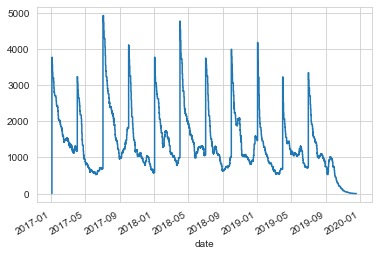

In [183]:
trades = pair_trade_data['side'].copy()
trades.loc[trades != 0] = 1
trades.loc[trades == 0] = -1
trades.sort_index().cumsum().plot()

In [184]:
pair_trade_data.to_hdf('backtest.h5', 'pair_trades')